# CS74 22S Final Project

## Data Cleaning and Preprocessing

Before we can begin applying our models to the data, we need to clean and preprocess it. <br>
First, we will split the data into our feature space and our target value. <br>
Next, we will handle NA's. <br>
Lastly, we will vectorize non-numerical data.

First, we import all necessary packages as well as the datasets.

In [228]:
import numpy as np
import pandas as pd

from nltk.stem.snowball import SnowballStemmer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn import metrics

from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

from sklearn.cluster import KMeans

In [38]:
train = pd.read_csv('Training.csv')
train.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,1,False,"11 12, 2016",C413C78E10E54C5DB41837889F36C1E8,565D194F38B1CC3F806EE677C61F639C,465E154EC79AFFAB5EB2607198B21433,all of the reviews for this product are fake.,"All fake reviews, beware.",1478908800,2.0,NaN,{'Size:': ' Polaris H4'},automotive
1,1,True,"12 6, 2016",490AE37808EFEE3AF4FE6DEBDEB5A4C8,0D66512A0A7F580523AB996378DF0F14,760C63E8E5E8DC3FAA01878D37BA5678,wrong part. our fault.,One Star,1480982400,NaN,NaN,NaN,automotive
2,1,True,"09 17, 2014",74A9FA5A64449BEE2A2E8E3F62872F0F,A0E45600FF2C5A779CB4314F379C253A,C6E4DD5C1C4EC09E90182644ED6CA9EF,this wire set it really sucks!!!,One Star,1410912000,NaN,NaN,NaN,automotive
3,1,True,"06 11, 2016",EB561158A2829D98B467FE03CC1E45F1,37AB9A82470595E0ACB88BAC48C150EE,F4892A77EA45C52F40AB17ED537EF9FF,"first use, it leaked instantly. even at 5 buck...",One Star,1465603200,NaN,NaN,"{'Color:': ' Clear', 'Style:': ' 45 Degree'}",automotive
4,1,True,"12 23, 2017",5045D801332850D21618DD13A697CD9B,5772FF30428EEB8E0258C1A53CA2EC50,522F0BBFF2B47F1D63FF781A0AB1D079,didn't fit,One Star,1513987200,NaN,NaN,NaN,automotive


In [39]:
test = pd.read_csv('Test.csv')
test.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,True,"07 23, 2015",28EA11D68FB7FF05B5ABB5989B0EDDD2,2CC19105CB9E7E4C30B1A399F3BFA181,B468F2974AA56619CF81B9DB66277892,ordered 318c and receive the 303c. my bad. i d...,Wrong filter,1437609600,NaN,NaN,NaN,automotive
1,True,"11 14, 2016",465EF4B95F3C23F3D2E0DF032806B593,44FF14695671384604654465F32F51BE,B9CBF62E157F0A8798A4D33BA089CE2B,slime must have a serious manufacturing defect...,Don't waste your time on the compressor lottery.,1479081600,6.0,NaN,NaN,automotive
2,True,"12 8, 2016",139CE33FEE21437434272524E638F60B,FD46962FBDA48B8BCB6BCCDE86515E83,68A0EDEBA61ACC7DD4096275BBFA6C8A,while the description says will not produce an...,Not error free in 2012 Mini Countryman S ALL4,1481155200,NaN,NaN,NaN,automotive
3,True,"06 16, 2016",5FAB0AEBEEF467F40843E12D1AD2176C,B602B679B1EDBD9C59BC91802E521324,5C6E597BBBCACE38B3335C3D02CB0522,"this keys could not start my truck, after cutt...","This keys could not start my truck, after cutt...",1466035200,NaN,NaN,{'Color:': ' Black'},automotive
4,False,"12 3, 2016",EEEFD48788F090F22767829BD219B24C,DA059E333E0AF68256582317DBEDA711,50DDC9EE6BA5B5E97F77CDC57CC32EFD,kept on trickle charger when the hd was not ri...,Kept on trickle charger when the HD was not ri...,1480723200,NaN,NaN,NaN,automotive


We check for NA's in the overall rating.

In [40]:
train['overall'].isna().sum()

0

 As there are none, we can move forward and create binary labels for each of the 4 cutoffs. We also preserve the 'overall'-column itself for multiclassification.

In [41]:
def classify(cutoff, row):
    if row['overall'] <= cutoff:
        return 0
    else: 
        return 1

In [42]:
overall = train['overall']
category = test['category']

labels = {}
for i in range(1, 5):
     labels["label_{0}".format(i)] = train.apply (lambda row: classify(i, row), axis = 1)

We select the columns that we want to use as features. We split the test data into an actual test dataset for our classification problem and into a dataset to be used for clustering in problem 3 which does not include the 'category' feature.

In [43]:
train = train[['verified', 'reviewText', 'summary', 'vote', 'category']]
test = test[['verified', 'reviewText', 'summary', 'vote', 'category']]
clustering_data = test[['reviewText', 'summary']].copy()

Again, we check for NA's as well as the column dtypes.

In [44]:
train.isna().sum(), test.isna().sum()

(verified          0
 reviewText        0
 summary           5
 vote          23142
 category          0
 dtype: int64,
 verified         0
 reviewText       0
 summary          3
 vote          3578
 category         0
 dtype: int64)

In [45]:
train.dtypes, test.dtypes

(verified         bool
 reviewText     object
 summary        object
 vote          float64
 category       object
 dtype: object,
 verified         bool
 reviewText     object
 summary        object
 vote          float64
 category       object
 dtype: object)

In this case, we do have some NA's in the 'summary' and the 'vote' columns. <br>
In the case of 'summary', an NA simply means that the reviewer did not include a summary, so we replace those NA's with an empty string. <br>
In the case of 'vote', an NA simply means that no other customer has found the review helpful, so we replace those NA's with 0s.

In [46]:
train['verified'] = train['verified'].astype('int')
test['verified'] = test['verified'].astype('int')

train['summary'] = train['summary'].replace(np.nan, '')
test['summary'] = test['summary'].replace(np.nan, '')
clustering_data['summary'] = clustering_data['summary'].replace(np.nan, '')

train['vote'] = train['vote'].replace(np.nan, 0)
test['vote'] = test['vote'].replace(np.nan, 0)
train['vote'] = train['vote'].astype('int')
test['vote'] = test['vote'].astype('int')

As part of the word vectorization process, we want to stem the words such that we are left with the informative word stems irrespective of word endings. We use the SnowballStemmer for this task.

In [47]:
stemmer = SnowballStemmer('english')
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(row):
    return (stemmer.stem(word) for word in analyzer(row))

Next, we create a simple pipeline to process the raw data into a fully vectorized form. We use a one-hot encoder to encode the categorical 'category' feature and vectorize the text features using term frequency–inverse document frequency. <br>
In addition to stemming, we also remove stop words and strip the words of accents. We further require words to appear in at least 10 reviews and in at most 90% of the reviews to filter out unimportant words. For the clusterization, we require words to appear in at least 300 reviews and in at most 60% of the reviews to reduce the number of columns to around 100.

In [48]:
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [49]:
text_transformer = Pipeline(steps = [('vectorizer', TfidfVectorizer(analyzer = stemmed_words,
                                                                    strip_accents = 'unicode',
                                                                    stop_words = 'english',
                                                                    min_df = 10,
                                                                    max_df = 0.9))])
text_transformer_cluster = Pipeline(steps = [('vectorizer', TfidfVectorizer(analyzer = stemmed_words,
                                                                    strip_accents = 'unicode',
                                                                    stop_words = 'english',
                                                                    min_df = 300,
                                                                    max_df = 0.6))])

In [50]:
preprocessor = ColumnTransformer(
    remainder = 'passthrough',
    transformers = [
        ('categorical', categorical_transformer, ['category']),
        ('text_1', text_transformer, 'reviewText'),
        ('text_2', text_transformer, 'summary')
])

preprocessor_clustering = ColumnTransformer(
    remainder = 'passthrough',
    transformers = [
        ('text_1', text_transformer_cluster, 'reviewText'),
        ('text_2', text_transformer_cluster, 'summary')
])

In [51]:
train_processed = preprocessor.fit_transform(train)
test_processed = preprocessor.fit_transform(test)
clustering_data_processed = preprocessor_clustering.fit_transform(clustering_data)

We quickly confirm that we have a reasonable number of features.

In [52]:
train_processed.shape, test_processed.shape, clustering_data_processed.shape

((29189, 7489), (4500, 2276), (4500, 109))

Our last step is to split our train data into train and validation datasets for each of the 4 labels and the overall rating.

In [124]:
train_val = {}
for key in labels.keys():
    data = []
    X_train, X_val, y_train, y_val = train_test_split(
        train_processed, labels.get(key), test_size = 0.1)
    data.append(X_train)
    data.append(X_val)
    data.append(y_train)
    data.append(y_val)
    train_val[str(key)] = data
    
data = []
X_train, X_val, y_train, y_val = train_test_split(
    train_processed, overall, test_size = 0.1)
data.append(X_train)
data.append(X_val)
data.append(y_train)
data.append(y_val)
    
train_val_overall = data

overall_binary = label_binarize(overall, classes = [1, 2, 3, 4, 5])
data_ovr = []
X_train, X_val, y_train, y_val = train_test_split(
    train_processed, overall_binary, test_size = 0.1)
data_ovr.append(X_train)
data_ovr.append(X_val)
data_ovr.append(y_train)
data_ovr.append(y_val)

train_val_overall_ovr = data_ovr

With this, we have finished the cleaning and preprocessing of our data. We can now go on to the training of our classification models.

## Problem 1: Binary Classification

We will use three models to classify the product reviews as good or bad: Logistic Regression, Perceptron, and Support Vector Machine. <br>
First, we will use Bayesian cross validation to tune our hyperparameters. <br>
Next, we will split our training data into a training and validation set and train our model on the training set using our optimal hyperparameters. <br>
Next, we will report the performance of our model using the validation set.

### Hyperparameter Tuning and Cross Validation

Our first step is hyperparameter tuning. We use Bayesian cross validation to find optimal hyperparameters. <br>
For each hyperparameter, we set up a space from which the Bayesian cross validation optimizer can choose. We exclude the l1 norm due to its extremely long runtime.

#### Logistic Regression

For logistic regression, we focus our hyperparameter tuning on the penalty and its regularization parameter C. We perform Bayesian cross validation on models for all cutoffs.

In [178]:
param_log = {'C': Real(1, 1000, prior = 'log-uniform'),
             'penalty': Categorical(['none', 'l2'])}

In [179]:
log_reg_1 = BayesSearchCV(LogisticRegression(max_iter = 10000,
                                             multi_class = 'ovr',
                                             class_weight = 'balanced',
                                             solver = 'saga'),
                          param_log,
                          n_iter = 20,
                          scoring = 'f1_macro',
                          n_jobs = 3,
                          cv = 5,
                          verbose = 3)
log_reg_2 = BayesSearchCV(LogisticRegression(max_iter = 10000,
                                             multi_class = 'ovr',
                                             class_weight = 'balanced',
                                             solver = 'saga'),
                          param_log,
                          n_iter = 20,
                          scoring = 'f1_macro',
                          n_jobs = 3,
                          cv = 5,
                          verbose = 3)
log_reg_3 = BayesSearchCV(LogisticRegression(max_iter = 10000,
                                             multi_class = 'ovr',
                                             class_weight = 'balanced',
                                             solver = 'saga'),
                          param_log,
                          n_iter = 20,
                          scoring = 'f1_macro',
                          n_jobs = 3,
                          cv = 5,
                          verbose = 3)
log_reg_4 = BayesSearchCV(LogisticRegression(max_iter = 10000,
                                             multi_class = 'ovr',
                                             class_weight = 'balanced',
                                             solver = 'saga'),
                          param_log,
                          n_iter = 20,
                          scoring = 'f1_macro',
                          n_jobs = 3,
                          cv = 5,
                          verbose = 3)


log_reg_cv = []
print('Cross validating on cutoff 1')
log_reg_cv.append(log_reg_1.fit(train_processed, labels.get('label_1')))
print('Cross validating on cutoff 2')
log_reg_cv.append(log_reg_2.fit(train_processed, labels.get('label_2')))
print('Cross validating on cutoff 3')
log_reg_cv.append(log_reg_3.fit(train_processed, labels.get('label_3')))
print('Cross validating on cutoff 4')
log_reg_cv.append(log_reg_4.fit(train_processed, labels.get('label_4')))

Cross validating on cutoff 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of

The results show that adding a penalty is preferrable over adding no penalty. This is because the penalty prevents the model from overfitting on the training data. <br>
We further see that both C values that are too low or too high perform poorly. This is because they either smooth out the model too heavily or not enough. That is why small C values which enforce heavy smoothing perform even worse than models without any penalty. <br>
Moderate C values perform the best.

In [189]:
for i in range(len(log_reg_cv)):
    display(pd.DataFrame.from_dict(log_reg_cv[i].cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,60.328722,3.932050,0.003189,0.001074,100.400279,l2,"{'C': 100.40027942079928, 'penalty': 'l2'}",0.734575,0.658755,0.757635,0.748307,0.786576,0.737169,0.042754,4
1,57.973827,3.302946,0.002582,0.000182,1.332299,none,"{'C': 1.3322990013726137, 'penalty': 'none'}",0.734575,0.658755,0.757635,0.748307,0.786576,0.737169,0.042754,4
2,57.991964,3.456090,0.002636,0.000310,32.340931,none,"{'C': 32.340930650314554, 'penalty': 'none'}",0.734404,0.658755,0.757635,0.748307,0.786576,0.737135,0.042756,18
3,59.202142,3.358737,0.002632,0.000217,1.050532,l2,"{'C': 1.0505315425601205, 'penalty': 'l2'}",0.734443,0.658904,0.757460,0.747282,0.785561,0.736730,0.042397,20
4,59.470128,3.826391,0.002985,0.000330,36.67024,l2,"{'C': 36.67023983152126, 'penalty': 'l2'}",0.734575,0.658755,0.757635,0.748307,0.786576,0.737169,0.042754,4
5,58.384563,3.610469,0.003111,0.000526,1.580564,none,"{'C': 1.5805640439576851, 'penalty': 'none'}",0.734575,0.658755,0.757635,0.748307,0.786576,0.737169,0.042754,4
6,59.299532,3.679690,0.002655,0.000296,13.578503,l2,"{'C': 13.578503418422013, 'penalty': 'l2'}",0.734745,0.658755,0.757635,0.748307,0.786576,0.737204,0.042752,2
7,58.596142,3.882446,0.002613,0.000346,1.628679,l2,"{'C': 1.6286787884212819, 'penalty': 'l2'}",0.734745,0.658755,0.757460,0.747554,0.786238,0.736951,0.042619,19
8,58.743918,3.472719,0.002829,0.000176,128.031335,l2,"{'C': 128.03133490941042, 'penalty': 'l2'}",0.734575,0.658755,0.757635,0.748307,0.786576,0.737169,0.042754,4
9,59.503005,3.838557,0.002662,0.000274,51.002467,l2,"{'C': 51.002466712181814, 'penalty': 'l2'}",0.734575,0.658755,0.757635,0.748307,0.786576,0.737169,0.042754,4


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,73.729480,8.418726,0.002661,0.000273,1.800866,none,"{'C': 1.8008660137658812, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
1,70.567599,7.456295,0.002666,0.000224,6.361019,l2,"{'C': 6.361019237444437, 'penalty': 'l2'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
2,71.090979,7.100148,0.002743,0.000216,2.680572,none,"{'C': 2.680572074201094, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
3,69.396619,7.247473,0.002822,0.000257,1.113157,l2,"{'C': 1.1131573671326587, 'penalty': 'l2'}",0.793414,0.721302,0.791740,0.774244,0.807529,0.777646,0.030088,20
4,71.462270,7.409430,0.003018,0.000540,2.069829,none,"{'C': 2.0698286820418845, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
5,71.275823,6.986360,0.002749,0.000268,1.49338,none,"{'C': 1.4933800941504498, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
6,70.473427,7.298386,0.002872,0.000473,2.645208,none,"{'C': 2.6452081330356263, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
7,71.086883,7.480855,0.002751,0.000214,36.368359,l2,"{'C': 36.368358838739105, 'penalty': 'l2'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
8,70.883109,7.195218,0.002660,0.000285,16.520272,none,"{'C': 16.52027219899, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2
9,70.472046,7.288141,0.002776,0.000344,130.541475,none,"{'C': 130.54147506772745, 'penalty': 'none'}",0.793769,0.721690,0.791905,0.774440,0.807695,0.777900,0.030024,2


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,83.330006,6.549868,0.002671,0.000296,1.166229,none,"{'C': 1.1662289034256625, 'penalty': 'none'}",0.831608,0.746784,0.830654,0.805704,0.831257,0.809201,0.032732,12
1,80.480916,6.558256,0.002597,0.000312,41.908971,l2,"{'C': 41.908971375188386, 'penalty': 'l2'}",0.831608,0.746784,0.830654,0.805904,0.831257,0.809241,0.032728,2
2,81.201945,6.045316,0.002794,0.000300,173.327904,l2,"{'C': 173.32790369223687, 'penalty': 'l2'}",0.831608,0.746784,0.830654,0.805904,0.831257,0.809241,0.032728,2
3,80.867595,6.640227,0.002686,0.000166,2.578071,none,"{'C': 2.578071484779218, 'penalty': 'none'}",0.831608,0.746784,0.830654,0.805704,0.831257,0.809201,0.032732,12
4,81.794441,6.015970,0.002745,0.000211,39.929939,none,"{'C': 39.92993895584859, 'penalty': 'none'}",0.831608,0.746784,0.830654,0.805704,0.831257,0.809201,0.032732,12
5,85.126654,7.370744,0.002971,0.000405,2.99201,l2,"{'C': 2.9920100940389216, 'penalty': 'l2'}",0.831054,0.746699,0.830654,0.806269,0.831257,0.809187,0.032678,20
6,85.433860,6.340311,0.002926,0.000347,20.555951,none,"{'C': 20.555951249129464, 'penalty': 'none'}",0.831608,0.746784,0.830654,0.805704,0.831257,0.809201,0.032732,12
7,85.404716,6.354425,0.002685,0.000213,21.815867,l2,"{'C': 21.815866833062028, 'penalty': 'l2'}",0.831608,0.746784,0.830654,0.805904,0.831257,0.809241,0.032728,2
8,83.093712,7.468226,0.002655,0.000280,106.263428,l2,"{'C': 106.26342849016086, 'penalty': 'l2'}",0.831608,0.746784,0.830654,0.805704,0.831257,0.809201,0.032732,12
9,80.713716,6.179491,0.002727,0.000266,22.742512,none,"{'C': 22.74251211713126, 'penalty': 'none'}",0.831608,0.746623,0.830654,0.805904,0.831257,0.809209,0.032789,8


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,62.221481,5.335967,0.002641,0.000234,1.971099,none,"{'C': 1.9710993328940112, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
1,60.622135,5.568051,0.002730,0.000326,2.060653,none,"{'C': 2.0606527634261624, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
2,60.124941,5.235808,0.002794,0.000328,172.237024,none,"{'C': 172.23702396819954, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789602,0.747466,0.775128,0.027833,17
3,59.407036,4.778521,0.002759,0.000279,1.502707,none,"{'C': 1.5027068817177605, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
4,59.763341,4.819908,0.002632,0.000246,1.820739,none,"{'C': 1.8207389259714528, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789602,0.747466,0.775128,0.027833,17
5,59.797522,5.498997,0.002600,0.000305,52.435997,l2,"{'C': 52.43599667144693, 'penalty': 'l2'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
6,59.875363,5.306545,0.002644,0.000231,3.117392,none,"{'C': 3.117391506538053, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
7,59.732487,5.075534,0.002758,0.000185,12.742045,none,"{'C': 12.742045406314782, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
8,60.439910,5.333580,0.002622,0.000246,162.804474,none,"{'C': 162.80447407140812, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4
9,59.635685,5.308281,0.002677,0.000312,79.567648,none,"{'C': 79.56764775382388, 'penalty': 'none'}",0.785275,0.739292,0.814008,0.789803,0.747466,0.775169,0.027854,4


#### Perceptron

For the perceptron, we again focus our hyperparameter tuning on the penalty and its regularization parameter alpha. We perform Bayesian cross validation on models for all cutoffs.

In [167]:
param_perceptron = {'alpha': Real(1e-10, 0.01, prior = 'log-uniform'),
                   'penalty': Categorical(['none', 'l2'])}

In [168]:
perceptron_1 = BayesSearchCV(Perceptron(max_iter = 10000,
                                      early_stopping = True,
                                      class_weight = 'balanced',
                                      validation_fraction = 0.1),
                             param_perceptron,
                             n_iter = 20,
                             scoring = 'f1_macro',
                             n_jobs = 3,
                             cv = 5,
                             verbose = 3)
perceptron_2 = BayesSearchCV(Perceptron(max_iter = 10000,
                                      early_stopping = True,
                                      class_weight = 'balanced',
                                      validation_fraction = 0.1),
                             param_perceptron,
                             n_iter = 20,
                             scoring = 'f1_macro',
                             n_jobs = 3,
                             cv = 5,
                             verbose = 3)
perceptron_3 = BayesSearchCV(Perceptron(max_iter = 10000,
                                      early_stopping = True,
                                      class_weight = 'balanced',
                                      validation_fraction = 0.1),
                             param_perceptron,
                             n_iter = 20,
                             scoring = 'f1_macro',
                             n_jobs = 3,
                             cv = 5,
                             verbose = 3)
perceptron_4 = BayesSearchCV(Perceptron(max_iter = 10000,
                                      early_stopping = True,
                                      class_weight = 'balanced',
                                      validation_fraction = 0.1),
                             param_perceptron,
                             n_iter = 20,
                             scoring = 'f1_macro',
                             n_jobs = 3,
                             cv = 5,
                             verbose = 3)

perceptron_cv = []
print('Cross validating on cutoff 1')
perceptron_cv.append(perceptron_1.fit(train_processed, labels.get('label_1')))
print('Cross validating on cutoff 2')
perceptron_cv.append(perceptron_2.fit(train_processed, labels.get('label_2')))
print('Cross validating on cutoff 3')
perceptron_cv.append(perceptron_3.fit(train_processed, labels.get('label_3')))
print('Cross validating on cutoff 4')
perceptron_cv.append(perceptron_4.fit(train_processed, labels.get('label_4')))

Cross validating on cutoff 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Cross validating on cutoff 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Cross validating on cutoff 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Cross validating on cutoff 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In this case, the results first showed that adding no penalty was preferrable over adding a penalty. This was surprising because we usually expect the penalty to prevent the model from overfitting on the training data like for logistic regression. However, for the perceptron models, those with penalty performed significantly worse than models without a penalty. <br>
An explanation for this behavior was that the chosen penalty alpha values were still too high leading to overly heavy smoothing even though we were already using alpha values in the e-06 range. <br>
Therefore, we chose a larger range of alphas to be considered. This time, as we expect, the results show that adding a penalty is preferrable over adding no penalty. Again, this is because the penalty prevents the model from overfitting on the training data. <br>
We further see that extremely small alpha values corresponding to less heavy smoothing perform best. Evidence that the range of alphas initially chosen was too narrow. That is why large alpha values which enforce heavy smoothing perform even worse than models without any penalty.

In [190]:
for i in range(len(perceptron_cv)):
    display(pd.DataFrame.from_dict(perceptron_cv[i].cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.120187,0.021955,0.003990,0.000723,0.000149,l2,"{'alpha': 0.00014852041728281528, 'penalty': '...",0.676386,0.563427,0.726501,0.679127,0.637249,0.656538,0.054481,19
1,0.086775,0.009630,0.003565,0.000463,0.0,none,"{'alpha': 3.6855063418474684e-10, 'penalty': '...",0.748569,0.601671,0.723953,0.720719,0.729502,0.704883,0.052501,2
2,0.118908,0.040060,0.003630,0.000650,0.0,l2,"{'alpha': 3.576436455546067e-07, 'penalty': 'l2'}",0.669198,0.599855,0.730458,0.740566,0.727120,0.693440,0.053050,16
3,0.085712,0.017365,0.003563,0.000218,0.0,l2,"{'alpha': 2.1316230379888548e-07, 'penalty': '...",0.662512,0.599637,0.724798,0.694735,0.739647,0.684266,0.049909,17
4,0.082921,0.010030,0.003259,0.000443,0.000048,l2,"{'alpha': 4.754468405076144e-05, 'penalty': 'l2'}",0.587736,0.597005,0.724294,0.716380,0.726846,0.670452,0.063914,18
5,0.107040,0.013177,0.004668,0.000911,0.000001,none,"{'alpha': 8.55978426302847e-07, 'penalty': 'no...",0.748569,0.601671,0.723953,0.720719,0.729502,0.704883,0.052501,2
6,0.104379,0.019048,0.004123,0.001093,0.0,l2,"{'alpha': 2.5521580202398864e-08, 'penalty': '...",0.674480,0.596165,0.777974,0.718524,0.731521,0.699733,0.061399,14
7,0.118386,0.025506,0.004291,0.000553,0.002044,l2,"{'alpha': 0.002043757983551493, 'penalty': 'l2'}",0.619123,0.394295,0.607065,0.610912,0.325239,0.511327,0.125720,20
8,0.121146,0.015168,0.004621,0.000641,0.0001,none,"{'alpha': 9.954228394450408e-05, 'penalty': 'n...",0.748569,0.601671,0.723953,0.720719,0.729502,0.704883,0.052501,2
9,0.093793,0.011677,0.003867,0.000726,0.000438,none,"{'alpha': 0.00043822815972559644, 'penalty': '...",0.748569,0.601671,0.723953,0.720719,0.729502,0.704883,0.052501,2


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.139653,0.013420,0.003949,0.001059,0.0,none,"{'alpha': 2.4840388537986294e-09, 'penalty': '...",0.758433,0.705086,0.767652,0.777437,0.762692,0.754260,0.025389,11
1,0.128482,0.010477,0.004092,0.000639,0.0,none,"{'alpha': 3.4328772642082575e-08, 'penalty': '...",0.758433,0.705086,0.767652,0.777437,0.762692,0.754260,0.025389,11
2,0.121119,0.012540,0.003065,0.000399,0.0,l2,"{'alpha': 2.3068443858014415e-10, 'penalty': '...",0.738136,0.705086,0.754540,0.774585,0.816548,0.757779,0.037173,7
3,0.122838,0.035680,0.003448,0.000546,0.001125,l2,"{'alpha': 0.0011250314168579044, 'penalty': 'l2'}",0.659127,0.520956,0.519447,0.612198,0.712767,0.604899,0.076129,19
4,0.113261,0.022545,0.003457,0.000674,0.0,l2,"{'alpha': 3.6233892673764226e-07, 'penalty': '...",0.776660,0.738532,0.758021,0.779388,0.768661,0.764252,0.014851,4
5,0.100161,0.010094,0.003687,0.000306,0.0,l2,"{'alpha': 8.027643261667202e-08, 'penalty': 'l2'}",0.773122,0.709487,0.800704,0.775239,0.752841,0.762279,0.030457,5
6,0.100097,0.019171,0.003008,0.000291,0.004217,l2,"{'alpha': 0.00421748616852952, 'penalty': 'l2'}",0.556609,0.494357,0.398726,0.573267,0.595855,0.523763,0.071029,20
7,0.104249,0.009350,0.003241,0.000432,0.0,none,"{'alpha': 3.554848917006502e-07, 'penalty': 'n...",0.758433,0.705086,0.767652,0.777437,0.762692,0.754260,0.025389,11
8,0.098987,0.016151,0.003446,0.000446,0.000002,l2,"{'alpha': 2.231944599513325e-06, 'penalty': 'l2'}",0.785745,0.732121,0.758186,0.791441,0.792209,0.771940,0.023480,1
9,0.136605,0.034956,0.003628,0.000353,0.0,l2,"{'alpha': 2.345505371109058e-08, 'penalty': 'l2'}",0.788381,0.657461,0.762918,0.759025,0.803578,0.754273,0.051116,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.137630,0.028673,0.003208,0.000350,0.0,none,"{'alpha': 4.638226164519682e-08, 'penalty': 'n...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
1,0.152652,0.028431,0.004131,0.001046,0.000261,none,"{'alpha': 0.00026071609619360986, 'penalty': '...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
2,0.132632,0.023090,0.003881,0.000350,0.000017,none,"{'alpha': 1.697766647072558e-05, 'penalty': 'n...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
3,0.147747,0.025944,0.003870,0.000797,0.0,none,"{'alpha': 2.463804381003887e-08, 'penalty': 'n...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
4,0.155438,0.027857,0.004123,0.000273,0.000349,none,"{'alpha': 0.00034931813768390843, 'penalty': '...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
5,0.141789,0.029528,0.003697,0.000262,0.0,l2,"{'alpha': 9.42794558347719e-10, 'penalty': 'l2'}",0.723862,0.755939,0.818627,0.797494,0.810251,0.781235,0.035878,2
6,0.149334,0.028517,0.003588,0.000492,0.0,none,"{'alpha': 1.769423148485956e-08, 'penalty': 'n...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
7,0.131484,0.021655,0.003449,0.000485,0.00008,none,"{'alpha': 8.010139867344239e-05, 'penalty': 'n...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10
8,0.125241,0.015805,0.003491,0.000179,0.0,l2,"{'alpha': 1.6800083027559393e-09, 'penalty': '...",0.723862,0.636427,0.840343,0.798844,0.827895,0.765474,0.076158,8
9,0.167253,0.033168,0.003979,0.000389,0.000001,none,"{'alpha': 6.980797549467179e-07, 'penalty': 'n...",0.725211,0.628909,0.814910,0.813239,0.813845,0.759223,0.073676,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.119133,0.025206,0.004028,0.000890,0.000024,l2,"{'alpha': 2.3553700324299677e-05, 'penalty': '...",0.695145,0.744788,0.736214,0.705321,0.652623,0.706818,0.032807,17
1,0.140356,0.032012,0.004627,0.000961,0.000001,l2,"{'alpha': 6.94541036544259e-07, 'penalty': 'l2'}",0.773668,0.768334,0.795207,0.789070,0.722367,0.769729,0.025627,1
2,0.109381,0.018243,0.003693,0.000655,0.0,l2,"{'alpha': 1.82819007913987e-08, 'penalty': 'l2'}",0.717860,0.555126,0.740216,0.772076,0.706053,0.698266,0.075022,19
3,0.104913,0.024204,0.003918,0.000425,0.000274,none,"{'alpha': 0.00027352071911737396, 'penalty': '...",0.725975,0.729395,0.796880,0.791984,0.738088,0.756465,0.031289,2
4,0.134280,0.037802,0.004343,0.000298,0.000063,none,"{'alpha': 6.281371297794277e-05, 'penalty': 'n...",0.725975,0.729395,0.796880,0.791984,0.738088,0.756465,0.031289,2
5,0.124868,0.025870,0.003779,0.000476,0.000002,l2,"{'alpha': 1.6033800601091439e-06, 'penalty': '...",0.792835,0.552378,0.801257,0.755415,0.735079,0.727393,0.090789,16
6,0.102221,0.017108,0.003277,0.000481,0.0,l2,"{'alpha': 1.2075974524664303e-07, 'penalty': '...",0.703659,0.552825,0.791536,0.748453,0.726555,0.704605,0.081240,18
7,0.103438,0.027666,0.003468,0.000393,0.0,none,"{'alpha': 1.780977760388899e-08, 'penalty': 'n...",0.725975,0.729395,0.796880,0.791984,0.738088,0.756465,0.031289,2
8,0.104623,0.007244,0.004617,0.001157,0.000001,l2,"{'alpha': 5.559021443916674e-07, 'penalty': 'l2'}",0.671252,0.560360,0.718647,0.788113,0.711716,0.690018,0.074935,20
9,0.108141,0.028646,0.003211,0.000554,0.0,none,"{'alpha': 1.3205795458234624e-10, 'penalty': '...",0.725975,0.729395,0.796880,0.791984,0.738088,0.756465,0.031289,2


#### Support Vector Machine

For the support vector machine, we focus our hyperparameter tuning on the regularization parameter C and the kernel used and its degree. We perform Bayesian cross validation on models for all cutoffs.

In [181]:
param_svm = [
    {'C': Real(1, 1000, prior = 'log-uniform'),
     'kernel': Categorical(['linear', 'poly', 'rbf']),
     'degree': Integer(1, 8)}]

In [182]:
svm_1 = BayesSearchCV(SVC(max_iter = 10000,
                        decision_function_shape = 'ovr',
                        class_weight = 'balanced'),
                      param_svm,
                      n_iter = 20,
                      scoring = 'f1_macro',
                      n_jobs = 3,
                      cv = 5,
                      verbose = 3)
svm_2 = BayesSearchCV(SVC(max_iter = 10000,
                        decision_function_shape = 'ovr',
                        class_weight = 'balanced'),
                      param_svm,
                      n_iter = 20,
                      scoring = 'f1_macro',
                      n_jobs = 3,
                      cv = 5,
                      verbose = 3)
svm_3 = BayesSearchCV(SVC(max_iter = 10000,
                        decision_function_shape = 'ovr',
                        class_weight = 'balanced'),
                      param_svm,
                      n_iter = 20,
                      scoring = 'f1_macro',
                      n_jobs = 3,
                      cv = 5,
                      verbose = 3)
svm_4 = BayesSearchCV(SVC(max_iter = 10000,
                        decision_function_shape = 'ovr',
                        class_weight = 'balanced'),
                      param_svm,
                      n_iter = 20,
                      scoring = 'f1_macro',
                      n_jobs = 3,
                      cv = 5,
                      verbose = 3)

svm_cv = []
print('Cross validating on cutoff 1')
svm_cv.append(svm_1.fit(train_processed, labels.get('label_1')))
print('Cross validating on cutoff 2')
svm_cv.append(svm_2.fit(train_processed, labels.get('label_2')))
print('Cross validating on cutoff 3')
svm_cv.append(svm_3.fit(train_processed, labels.get('label_3')))
print('Cross validating on cutoff 4')
svm_cv.append(svm_4.fit(train_processed, labels.get('label_4')))

Cross validating on cutoff 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In this case, the results first showed that the best C values were the highest value in our range ($C=10$). This indicated that the range of Cs was too narrow and that the best C value was still oversmoothing the model. <br>
Therefore, we chose a larger range of Cs to be considered. This time, as we expect, the results show that high C values, with the exception of cutoff 1, above the initial range  corresponding to less heavy smoothing perform best. Evidence that the range of Cs initially chosen was too narrow. That is also why small C values which enforce heavy smoothing perform worst. <br>
The best performing kernel is mostly 'rbf' of varying degree, again with the exception of cutoff 1 which performs best with a linear kernel. This indicates that the data on cutoff 1 is best separated with a linear separation line. All other cutoffs are not well linearly separable.  

In [191]:
for i in range(len(svm_cv)):
    display(pd.DataFrame.from_dict(svm_cv[i].cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,121.707579,2.059168,23.528320,2.006528,1.668599,4,poly,"{'C': 1.6685986285370322, 'degree': 4, 'kernel...",0.445347,0.454567,0.445513,0.449452,0.445871,0.448150,0.003546,15
1,110.302837,4.970454,13.634440,0.909053,424.273355,5,linear,"{'C': 424.2733553968315, 'degree': 5, 'kernel'...",0.700816,0.661690,0.690959,0.718263,0.671261,0.688598,0.020295,9
2,117.614810,5.774337,14.456410,0.939636,5.378136,2,linear,"{'C': 5.378136429493232, 'degree': 2, 'kernel'...",0.697324,0.679229,0.746399,0.759117,0.708164,0.718047,0.030082,4
3,134.057803,2.458088,24.528465,2.322937,180.112303,6,poly,"{'C': 180.11230310919453, 'degree': 6, 'kernel...",0.169559,0.169559,0.169441,0.169441,0.444737,0.224547,0.110095,16
4,127.515057,5.397706,26.551268,2.080212,1.74779,3,rbf,"{'C': 1.7477895455956345, 'degree': 3, 'kernel...",0.620566,0.628587,0.579867,0.532699,0.546637,0.581671,0.038322,13
5,136.827127,2.376735,24.666781,2.104671,1.841362,7,poly,"{'C': 1.841362338342327, 'degree': 7, 'kernel'...",0.169559,0.169559,0.169441,0.169441,0.444737,0.224547,0.110095,16
6,116.235757,5.484136,14.002553,0.967959,10.606214,7,linear,"{'C': 10.606213810108066, 'degree': 7, 'kernel...",0.703109,0.657545,0.674160,0.706147,0.698938,0.687980,0.018954,11
7,134.177704,2.645350,24.240701,2.171458,1.028812,6,poly,"{'C': 1.0288122745915487, 'degree': 6, 'kernel...",0.169559,0.169559,0.169441,0.169441,0.444627,0.224525,0.110051,20
8,135.770819,3.232884,24.600736,2.272703,86.136957,7,poly,"{'C': 86.13695722273634, 'degree': 7, 'kernel'...",0.169559,0.169559,0.169441,0.169441,0.444737,0.224547,0.110095,16
9,139.030828,2.993897,24.744752,2.228397,4.277915,8,poly,"{'C': 4.2779150074453485, 'degree': 8, 'kernel...",0.169559,0.169559,0.169441,0.169441,0.444737,0.224547,0.110095,16


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,132.174908,7.200881,16.836787,0.633522,68.249673,6,linear,"{'C': 68.2496731426473, 'degree': 6, 'kernel':...",0.619805,0.690925,0.705806,0.582543,0.673846,0.654585,0.046292,15
1,138.188842,3.946975,25.923480,1.847401,28.670752,2,poly,"{'C': 28.670752116012853, 'degree': 2, 'kernel...",0.383890,0.417193,0.379107,0.381596,0.380964,0.388550,0.014403,16
2,132.039920,3.699052,25.605312,2.239795,4.504494,5,poly,"{'C': 4.504493664760567, 'degree': 5, 'kernel'...",0.372636,0.375462,0.371973,0.372432,0.372608,0.373022,0.001243,18
3,129.198592,7.860026,18.152757,0.906618,1.899382,4,linear,"{'C': 1.8993822724807832, 'degree': 4, 'kernel...",0.801898,0.742663,0.755199,0.802939,0.824089,0.785358,0.031033,9
4,131.585981,12.429164,26.566260,2.571206,140.764565,7,poly,"{'C': 140.76456537502753, 'degree': 7, 'kernel...",0.371718,0.373462,0.371582,0.371650,0.372217,0.372126,0.000705,20
5,123.997742,2.268964,24.477247,2.299853,33.649062,3,poly,"{'C': 33.649061798548345, 'degree': 3, 'kernel...",0.373211,0.382866,0.374193,0.372481,0.373252,0.375201,0.003871,17
6,130.671477,8.063715,16.967254,0.420428,24.494637,4,linear,"{'C': 24.494636575058486, 'degree': 4, 'kernel...",0.718163,0.659377,0.735303,0.728627,0.764453,0.721184,0.034514,13
7,130.835398,7.964846,16.785711,0.601520,48.740824,4,linear,"{'C': 48.74082397774886, 'degree': 4, 'kernel'...",0.734292,0.669888,0.724588,0.720307,0.675017,0.704818,0.026862,14
8,148.241075,7.923904,20.995293,1.069319,92.443178,2,rbf,"{'C': 92.44317784889552, 'degree': 2, 'kernel'...",0.810882,0.731775,0.772463,0.797257,0.807276,0.783931,0.029328,10
9,132.831661,14.241059,26.372390,3.433855,234.215908,6,poly,"{'C': 234.21590753227403, 'degree': 6, 'kernel...",0.371718,0.373462,0.371973,0.372568,0.372676,0.372479,0.000608,19


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,105.750195,52.309917,22.302673,11.300375,3.73861,8,poly,"{'C': 3.738610066024699, 'degree': 8, 'kernel'...",0.378539,0.378539,0.378539,0.378473,0.281069,0.359032,0.038982,17
1,121.161751,7.800318,15.697882,0.599790,88.0679,6,linear,"{'C': 88.0679001859861, 'degree': 6, 'kernel':...",0.756544,0.716123,0.749741,0.659376,0.760614,0.728480,0.037948,12
2,119.450653,7.395655,15.524667,0.710291,613.302495,5,linear,"{'C': 613.3024953274389, 'degree': 5, 'kernel'...",0.669808,0.714410,0.731162,0.648054,0.630772,0.678841,0.038322,14
3,123.131956,8.086870,17.238497,0.782165,1.963262,8,linear,"{'C': 1.9632619762092127, 'degree': 8, 'kernel...",0.822914,0.745285,0.817275,0.810931,0.841057,0.807493,0.032685,8
4,135.146598,6.925537,26.734071,1.427881,3.712242,1,rbf,"{'C': 3.7122419147729304, 'degree': 1, 'kernel...",0.845353,0.758025,0.835382,0.824817,0.830052,0.818726,0.031101,3
5,142.220409,8.320616,20.013815,0.875561,80.993575,5,rbf,"{'C': 80.99357514941153, 'degree': 5, 'kernel'...",0.832441,0.759532,0.817482,0.815961,0.826371,0.810358,0.026113,7
6,121.739641,3.691766,24.996768,2.119855,12.724171,5,poly,"{'C': 12.724170586035065, 'degree': 5, 'kernel...",0.297327,0.323454,0.291643,0.293611,0.282332,0.297673,0.013806,19
7,104.668784,51.774382,22.417314,11.351068,2.496168,8,poly,"{'C': 2.496167509988539, 'degree': 8, 'kernel'...",0.378539,0.378539,0.378539,0.378473,0.281069,0.359032,0.038982,17
8,115.982358,2.425487,23.984894,2.582482,47.457734,4,poly,"{'C': 47.45773371799528, 'degree': 4, 'kernel'...",0.281666,0.286106,0.281941,0.281488,0.282154,0.282671,0.001732,20
9,138.701269,6.926475,27.099483,1.095296,4.91267,3,rbf,"{'C': 4.912669582978405, 'degree': 3, 'kernel'...",0.844195,0.756030,0.844216,0.821856,0.837591,0.820778,0.033388,2


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,113.083520,2.624289,23.337762,1.873047,41.526202,2,poly,"{'C': 41.52620212620767, 'degree': 2, 'kernel'...",0.183410,0.187160,0.344074,0.435296,0.214872,0.272962,0.100165,17
1,105.936129,3.779662,22.933526,1.743742,33.811394,5,poly,"{'C': 33.81139412611271, 'degree': 5, 'kernel'...",0.187993,0.222509,0.172402,0.180607,0.162894,0.185281,0.020407,19
2,117.371124,5.748851,14.001243,0.912456,425.243358,5,rbf,"{'C': 425.2433577721852, 'degree': 5, 'kernel'...",0.779833,0.731337,0.777101,0.754242,0.773077,0.763118,0.018237,10
3,106.154359,3.565852,23.143337,1.618792,164.710273,5,poly,"{'C': 164.71027272485495, 'degree': 5, 'kernel...",0.201698,0.245756,0.178096,0.187768,0.162894,0.195243,0.028247,18
4,94.121751,6.188676,11.888499,0.689432,323.385859,2,linear,"{'C': 323.3858585329943, 'degree': 2, 'kernel'...",0.693371,0.695721,0.739062,0.727016,0.747753,0.720585,0.022269,13
5,93.946768,6.443300,11.893049,0.720879,825.987563,5,linear,"{'C': 825.9875633838344, 'degree': 5, 'kernel'...",0.660822,0.695721,0.739062,0.727016,0.747753,0.714075,0.031933,15
6,93.878622,6.294879,11.876438,0.756672,359.633282,6,linear,"{'C': 359.63328185083924, 'degree': 6, 'kernel...",0.693371,0.695721,0.739062,0.727016,0.747753,0.720585,0.022269,13
7,120.814135,6.673582,14.576081,0.804064,219.199887,6,rbf,"{'C': 219.19988736844917, 'degree': 6, 'kernel...",0.788235,0.751087,0.800006,0.767787,0.769939,0.775411,0.017024,8
8,101.635368,17.841434,22.188302,3.984652,315.906172,7,poly,"{'C': 315.906172472649, 'degree': 7, 'kernel':...",0.176159,0.195269,0.169058,0.176408,0.163244,0.176028,0.010792,20
9,116.065447,6.684000,16.354268,0.776002,76.52267,7,rbf,"{'C': 76.52266983219229, 'degree': 7, 'kernel'...",0.797526,0.746714,0.807863,0.780694,0.786618,0.783883,0.020786,3


This concludes the cross validation and hyperparameter tuning for our binary classifiers.

### Retraining and Validation

In this stage, we will retrain our binary classifiers using the optimal hyperparameters we found. Then, we will validate and report the performance of our models using macro F1 score, accuracy, AUC, confusion matrix, and ROC.

#### Logistic Regression

We print out the best hyperparamters and retrain our logistic regression models on our training data.

In [192]:
for i in range(len(log_reg_cv)):
    print(log_reg_cv[i].best_estimator_, log_reg_cv[i].best_score_)

LogisticRegression(C=5.406627635072547, class_weight='balanced', max_iter=10000,
                   multi_class='ovr', solver='saga') 0.7373048043501699
LogisticRegression(C=6.203229105999802, class_weight='balanced', max_iter=10000,
                   multi_class='ovr', solver='saga') 0.7779317041163585
LogisticRegression(C=7.6335711103013235, class_weight='balanced',
                   max_iter=10000, multi_class='ovr', solver='saga') 0.8092681207943773
LogisticRegression(C=5.393614808468759, class_weight='balanced', max_iter=10000,
                   multi_class='ovr', solver='saga') 0.7753050925937182


In [203]:
log_reg_1_optimal = LogisticRegression(C = 5.406627635072547,
                                       max_iter = 10000,
                                       multi_class = 'ovr',
                                       class_weight = 'balanced',
                                       penalty = 'l2',
                                       solver = 'saga')
log_reg_2_optimal = LogisticRegression(C = 6.203229105999802,
                                       max_iter = 10000,
                                       multi_class = 'ovr',
                                       class_weight = 'balanced',
                                       penalty = 'l2',
                                       solver = 'saga')
log_reg_3_optimal = LogisticRegression(C = 7.6335711103013235,
                                       max_iter = 10000,
                                       multi_class = 'ovr',
                                       class_weight = 'balanced',
                                       penalty = 'l2',
                                       solver = 'saga')
log_reg_4_optimal = LogisticRegression(C = 5.393614808468759,
                                       max_iter = 10000,
                                       multi_class = 'ovr',
                                       class_weight = 'balanced',
                                       penalty = 'l2',
                                       solver = 'saga')

log_reg_optimal = []
print('Training on cutoff 1')
log_reg_optimal.append(log_reg_1_optimal.fit(train_val.get('label_1')[0], train_val.get('label_1')[2]))
print('Training on cutoff 2')
log_reg_optimal.append(log_reg_2_optimal.fit(train_val.get('label_2')[0], train_val.get('label_2')[2]))
print('Training on cutoff 3')
log_reg_optimal.append(log_reg_3_optimal.fit(train_val.get('label_3')[0], train_val.get('label_3')[2]))
print('Training on cutoff 4')
log_reg_optimal.append(log_reg_4_optimal.fit(train_val.get('label_4')[0], train_val.get('label_4')[2]))

Training on cutoff 1
Training on cutoff 2
Training on cutoff 3
Training on cutoff 4


#### Perceptron

We print out the best hyperparamters and retrain our perceptron models on our training data.

In [193]:
for i in range(len(perceptron_cv)):
    print(perceptron_cv[i].best_estimator_, perceptron_cv[i].best_score_)

Perceptron(alpha=1.5455789312690544e-09, class_weight='balanced',
           early_stopping=True, max_iter=10000, penalty='l2') 0.7067836650018764
Perceptron(alpha=2.231944599513325e-06, class_weight='balanced',
           early_stopping=True, max_iter=10000, penalty='l2') 0.7719403732207553
Perceptron(alpha=9.634899155227715e-07, class_weight='balanced',
           early_stopping=True, max_iter=10000, penalty='l2') 0.7863913573823946
Perceptron(alpha=6.94541036544259e-07, class_weight='balanced',
           early_stopping=True, max_iter=10000, penalty='l2') 0.7697290847852886


In [204]:
perceptron_1_optimal = Perceptron(alpha = 1.5455789312690544e-09,
                                  max_iter = 10000,
                                  early_stopping = True,
                                  class_weight = 'balanced',
                                  penalty = 'l2')
perceptron_2_optimal = Perceptron(alpha = 2.231944599513325e-06,
                                  max_iter = 10000,
                                  early_stopping = True,
                                  class_weight = 'balanced',
                                  penalty = 'l2')
perceptron_3_optimal = Perceptron(alpha = 9.634899155227715e-07,
                                  max_iter = 10000,
                                  early_stopping = True,
                                  class_weight = 'balanced',
                                  penalty = 'l2')
perceptron_4_optimal = Perceptron(alpha = 6.94541036544259e-07,
                                  max_iter = 10000, 
                                  early_stopping = True,
                                  class_weight = 'balanced',
                                  penalty = 'l2')

perceptron_optimal = []
print('Training on cutoff 1')
perceptron_optimal.append(perceptron_1_optimal.fit(train_val.get('label_1')[0], train_val.get('label_1')[2]))
print('Training on cutoff 2')
perceptron_optimal.append(perceptron_2_optimal.fit(train_val.get('label_2')[0], train_val.get('label_2')[2]))
print('Training on cutoff 3')
perceptron_optimal.append(perceptron_3_optimal.fit(train_val.get('label_3')[0], train_val.get('label_3')[2]))
print('Training on cutoff 4')
perceptron_optimal.append(perceptron_4_optimal.fit(train_val.get('label_4')[0], train_val.get('label_4')[2]))

Training on cutoff 1
Training on cutoff 2
Training on cutoff 3
Training on cutoff 4


#### Support Vector Machine

We print out the best hyperparamters and retrain our support vector machine models on our training data.

In [194]:
for i in range(len(svm_cv)):
    print(svm_cv[i].best_estimator_, svm_cv[i].best_score_)

SVC(C=1.0014121571422898, class_weight='balanced', degree=4, kernel='linear',
    max_iter=10000) 0.7537108877227849
SVC(C=14.546673386127173, class_weight='balanced', degree=7, max_iter=10000) 0.8059970269845229
SVC(C=16.68665208307514, class_weight='balanced', max_iter=10000) 0.8283683203048959
SVC(C=43.302665604497534, class_weight='balanced', degree=1, max_iter=10000) 0.7887810908815818


We can see that the support vector machine models do not converge within the maximum iterations. However, they still exhibit good performance within our computational restraints so we choose to stay with a maximum number of 10,000 iterations.

In [205]:
svm_1_optimal = SVC(C = 1.0014121571422898,
                    kernel = 'linear',
                    max_iter = 10000,
                    decision_function_shape = 'ovr',
                    class_weight = 'balanced')
svm_2_optimal = SVC(C = 14.546673386127173,
                    kernel = 'rbf',
                    degree = 7,
                    max_iter = 10000,
                    decision_function_shape = 'ovr',
                    class_weight = 'balanced')
svm_3_optimal = SVC(C = 16.68665208307514,
                    kernel = 'rbf',
                    degree = 3,
                    max_iter = 10000,
                    decision_function_shape = 'ovr',
                    class_weight = 'balanced')
svm_4_optimal = SVC(C = 43.302665604497534,
                    kernel = 'rbf',
                    degree = 1,
                    max_iter = 10000,
                    decision_function_shape = 'ovr',
                    class_weight = 'balanced')

svm_optimal = []
print('Training on cutoff 1')
svm_optimal.append(svm_1_optimal.fit(train_val.get('label_1')[0], train_val.get('label_1')[2]))
print('Training on cutoff 2')
svm_optimal.append(svm_2_optimal.fit(train_val.get('label_2')[0], train_val.get('label_2')[2]))
print('Training on cutoff 3')
svm_optimal.append(svm_3_optimal.fit(train_val.get('label_3')[0], train_val.get('label_3')[2]))
print('Training on cutoff 4')
svm_optimal.append(svm_4_optimal.fit(train_val.get('label_4')[0], train_val.get('label_4')[2]))

Training on cutoff 1


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on cutoff 2


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on cutoff 3


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on cutoff 4


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#### Validation

Finally, we can now report the performance of our models on the validation dataset. Generally, the support vector machine models perform the best and the perceptron models perform the worst. However, we have to keep in mind that the training of the support vector machine models is a lot more computationally expensive. Meanwhile the perceptron is substantially faster while still exhibiting generally good performance almost on par with logistic regression. <br>
Only for cutoff 3, the perceptron performs significantly worse than the other two models.

label_1
Logistic Regression F1 Macro Score:0.739931222177683
Logistic Regression Accuracy:0.7989037341555327
Logistic Regression AUC:0.8814129747239374
Perceptron F1 Macro Score:0.7511123855298851
Perceptron Accuracy:0.8074683110654334
Perceptron AUC:0.8801656233069632
Support Vector Machine F1 Macro Score:0.7725713800694805
Support Vector Machine Accuracy:0.8352175402535115
Support Vector Machine AUC:0.8955508059918252


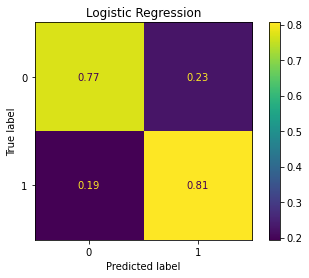

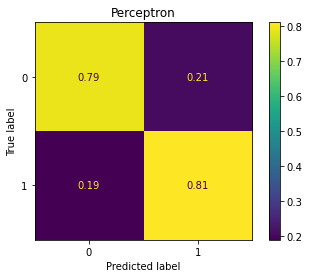

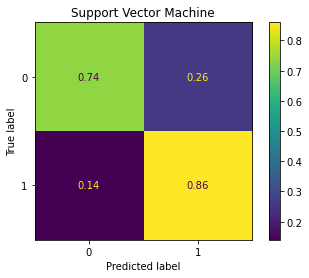

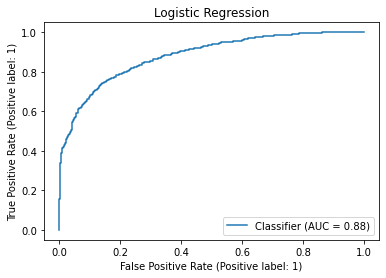

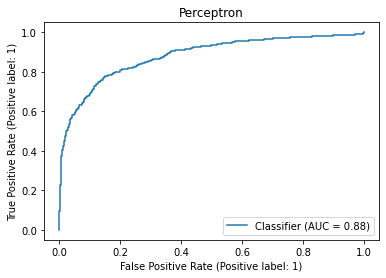

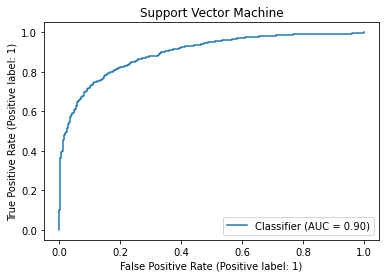

label_2
Logistic Regression F1 Macro Score:0.8059358674112772
Logistic Regression Accuracy:0.8088386433710175
Logistic Regression AUC:0.8985141519154791
Perceptron F1 Macro Score:0.8006359372865663
Perceptron Accuracy:0.802672147995889
Perceptron AUC:0.9070861636837179
Support Vector Machine F1 Macro Score:0.8283581736688442
Support Vector Machine Accuracy:0.8338472079479273
Support Vector Machine AUC:0.9164928057906956


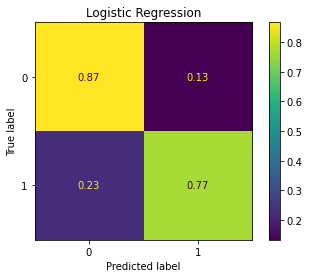

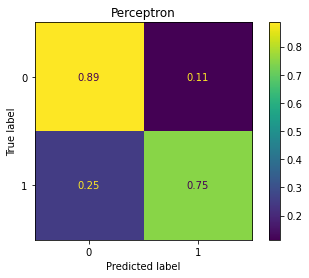

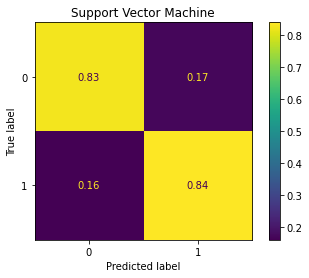

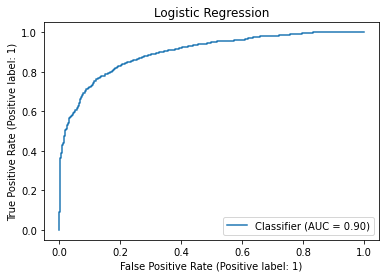

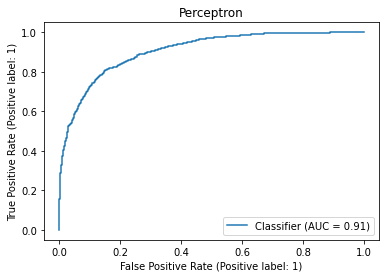

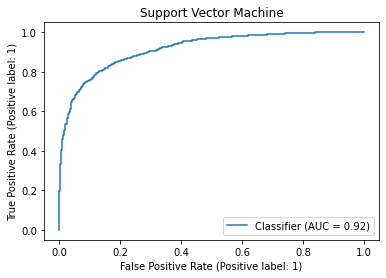

label_3
Logistic Regression F1 Macro Score:0.8313499384859546
Logistic Regression Accuracy:0.84138403562864
Logistic Regression AUC:0.9115542791025236
Perceptron F1 Macro Score:0.7471804565992827
Perceptron Accuracy:0.750256937307297
Perceptron AUC:0.7492896073957445
Support Vector Machine F1 Macro Score:0.8547455126628964
Support Vector Machine Accuracy:0.8602261048304214
Support Vector Machine AUC:0.9316186343371322


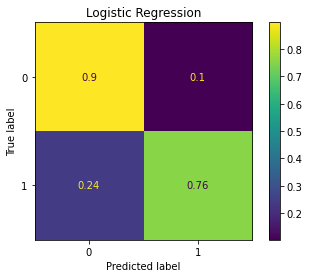

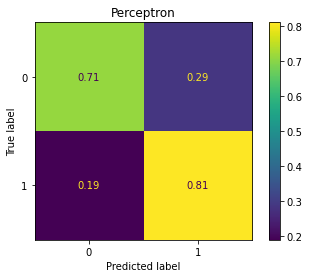

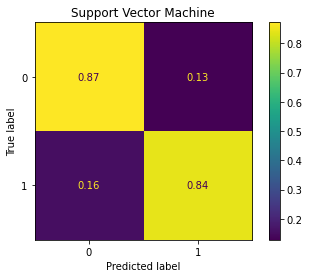

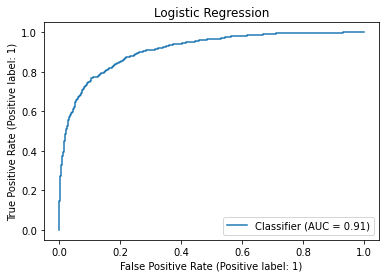

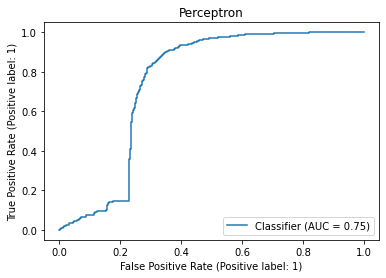

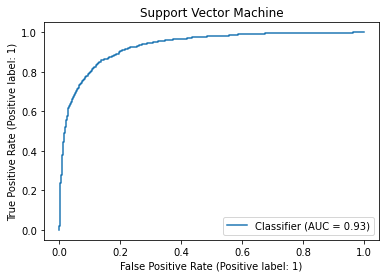

label_4
Logistic Regression F1 Macro Score:0.8004071150703402
Logistic Regression Accuracy:0.8660500171291539
Logistic Regression AUC:0.9143905319496444
Perceptron F1 Macro Score:0.7887519029193701
Perceptron Accuracy:0.8646796848235697
Perceptron AUC:0.845047439283777
Support Vector Machine F1 Macro Score:0.8076599950580677
Support Vector Machine Accuracy:0.868448098663926
Support Vector Machine AUC:0.9221068983916909


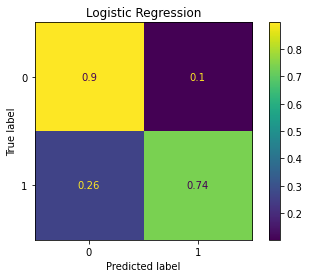

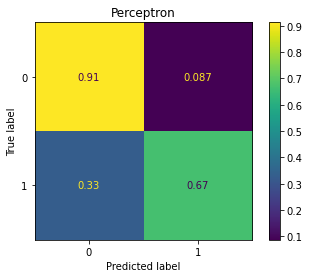

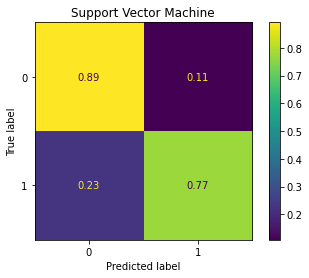

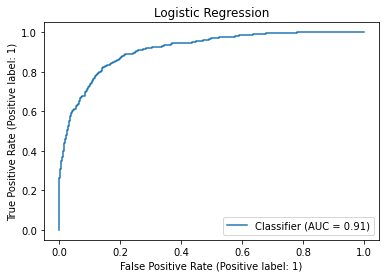

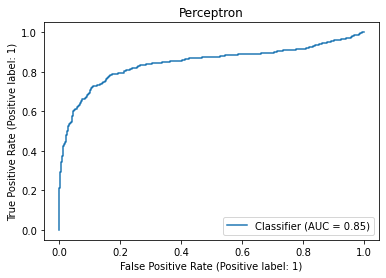

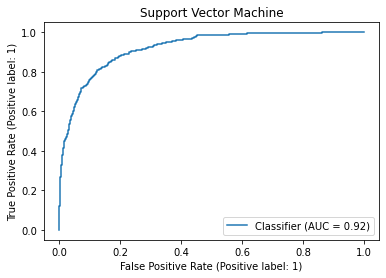

In [206]:
i = 0
for key in train_val.keys():
    print(key)
    log_reg_y_pred = log_reg_optimal[i].predict(train_val.get(key)[1])
    log_reg_y_scores = log_reg_optimal[i].decision_function(train_val.get(key)[1])
    log_reg_cm = metrics.confusion_matrix(train_val.get(key)[3], log_reg_y_pred, normalize = 'true') 

    print('Logistic Regression F1 Macro Score:' + str(metrics.f1_score(train_val.get(key)[3], log_reg_y_pred, average = 'macro')))
    print('Logistic Regression Accuracy:' + str(metrics.accuracy_score(train_val.get(key)[3], log_reg_y_pred)))
    print('Logistic Regression AUC:' + str(metrics.roc_auc_score(train_val.get(key)[3], log_reg_y_scores)))

    
    perceptron_y_pred = perceptron_optimal[i].predict(train_val.get(key)[1])
    perceptron_y_scores = perceptron_optimal[i].decision_function(train_val.get(key)[1])
    perceptron_cm = metrics.confusion_matrix(train_val.get(key)[3], perceptron_y_pred, normalize = 'true') 

    print('Perceptron F1 Macro Score:' + str(metrics.f1_score(train_val.get(key)[3], perceptron_y_pred, average = 'macro')))
    print('Perceptron Accuracy:' + str(metrics.accuracy_score(train_val.get(key)[3], perceptron_y_pred)))
    print('Perceptron AUC:' + str(metrics.roc_auc_score(train_val.get(key)[3], perceptron_y_scores)))

                                                                  
    svm_y_pred = svm_optimal[i].predict(train_val.get(key)[1])
    svm_y_scores = svm_optimal[i].decision_function(train_val.get(key)[1])
    svm_cm = metrics.confusion_matrix(train_val.get(key)[3], svm_y_pred, normalize = 'true')

    print('Support Vector Machine F1 Macro Score:' + str(metrics.f1_score(train_val.get(key)[3], svm_y_pred, average = 'macro')))
    print('Support Vector Machine Accuracy:' + str(metrics.accuracy_score(train_val.get(key)[3], svm_y_pred)))
    print('Support Vector Machine AUC:' + str(metrics.roc_auc_score(train_val.get(key)[3], svm_y_scores)))

                                                    
    log_reg_cm_plot = metrics.ConfusionMatrixDisplay(log_reg_cm).plot()
    plt.title('Logistic Regression')
    perceptron_cm_plot = metrics.ConfusionMatrixDisplay(perceptron_cm).plot()
    plt.title('Perceptron')
    svm_cm_plot = metrics.ConfusionMatrixDisplay(svm_cm).plot()
    plt.title('Support Vector Machine')
    
    metrics.RocCurveDisplay.from_predictions(train_val.get(key)[3], log_reg_y_scores)
    plt.title('Logistic Regression')
    metrics.RocCurveDisplay.from_predictions(train_val.get(key)[3], perceptron_y_scores)
    plt.title('Perceptron')
    metrics.RocCurveDisplay.from_predictions(train_val.get(key)[3], svm_y_scores)
    plt.title('Support Vector Machine')
    
    plt.show()
    
    i += 1

## Problem 2: Multiclass Classification

We will use our three models to predict the rating of the product reviews: Logistic Regression, Perceptron, and Support Vector Machine. <br>
First, we will use Bayesian cross validation to tune our hyperparameters. <br>
Next, we will split our training data into a training and validation set and train our model on the training set using our optimal hyperparameters. <br>
Next, we will report the performance of our model using the validation set.

### Hyperparameter Tuning and Cross Validation

Our first step is hyperparameter tuning. We use Bayesian cross validation to find optimal hyperparameters. <br>
For each hyperparameter, we use the space we already set up from which the Bayesian cross validation optimizer can choose. Again, we exclude the l1 norm due to its extremely long runtime.

#### Logistic Regression

In [184]:
log_reg_multi = BayesSearchCV(LogisticRegression(max_iter = 10000,
                                                 multi_class = 'ovr',
                                                 class_weight = 'balanced',
                                                 solver = 'saga'),
                              param_log_multi,
                              n_iter = 20,
                              scoring = 'f1_macro',
                              n_jobs = 3,
                              cv = 5,
                              verbose = 3)

log_reg_multi.fit(train_processed, overall)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


BayesSearchCV(cv=5,
              estimator=LogisticRegression(class_weight='balanced',
                                           max_iter=10000, multi_class='ovr',
                                           solver='saga'),
              n_iter=20, n_jobs=3, scoring='f1_macro',
              search_spaces={'C': Real(low=1, high=200, prior='log-uniform', transform='normalize'),
                             'penalty': Categorical(categories=('none', 'l2'), prior=None)},
              verbose=3)

In this case, the results first showed that adding no penalty was preferrable over adding a penalty. This was surprising because we usually expect the penalty to prevent the model from overfitting on the training data. However, for the multiclassification logistic regression model, those with penalty performed significantly worse than models without a penalty. <br>
An explanation for this behavior was that the chosen penalty C values were still too low leading to overly heavy smoothing similar to the logistic regression in problem 1. <br>
Therefore, we chose a larger range of Cs to be considered. This time, as we expect, the results show that adding a penalty is preferrable over adding no penalty. Again, this is because the penalty prevents the model from overfitting on the training data. <br>
We further see that large C values corresponding to less heavy smoothing perform best. Evidence that the range of Cs initially chosen was too narrow. That is why small C values which enforce heavy smoothing perform even worse than models without any penalty. In fact, choosing no penalty performed just as well as choosing an l2 penalty with certain C values. However, in order to prevent overfitting, we choose the hyperparameters with l2 penalty as the optimal hyperparameters.

In [195]:
pd.DataFrame.from_dict(log_reg_multi.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,313.544969,28.113437,0.004250,0.000925,3.213798,none,"{'C': 3.2137982805992236, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567841,0.549926,0.548663,0.028118,7
1,311.621308,28.535137,0.003951,0.000427,10.521183,none,"{'C': 10.52118273532941, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567587,0.549926,0.548612,0.028084,13
2,315.819474,18.673034,0.004101,0.000499,18.822236,none,"{'C': 18.822236289859806, 'penalty': 'none'}",0.540424,0.500877,0.583858,0.567754,0.549926,0.548568,0.028129,17
3,317.304318,32.658050,0.004187,0.000438,25.109558,none,"{'C': 25.109557581713574, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567754,0.549926,0.548645,0.028107,9
4,313.582922,30.764508,0.003998,0.000534,49.553007,none,"{'C': 49.553006657522296, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567841,0.549926,0.548663,0.028118,7
5,313.880785,29.362898,0.004117,0.000404,1.153018,none,"{'C': 1.1530178523151455, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567587,0.549926,0.548612,0.028084,13
6,312.132264,28.866032,0.004277,0.000451,16.528368,none,"{'C': 16.528368121822094, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567859,0.549926,0.548666,0.028121,1
7,311.060322,29.631025,0.004193,0.000424,30.901106,l2,"{'C': 30.90110564034009, 'penalty': 'l2'}",0.540812,0.500877,0.583858,0.567859,0.549926,0.548666,0.028121,1
8,313.535366,28.397223,0.004395,0.000332,6.855183,none,"{'C': 6.8551831117395094, 'penalty': 'none'}",0.540812,0.500877,0.583858,0.567859,0.549926,0.548666,0.028121,1
9,312.667698,28.778340,0.004331,0.000909,36.89554,l2,"{'C': 36.89553973659502, 'penalty': 'l2'}",0.540812,0.500877,0.583858,0.567859,0.549926,0.548666,0.028121,1


#### Perceptron

In [186]:
perceptron_multi = BayesSearchCV(Perceptron(max_iter = 10000,
                                            early_stopping = True,
                                            class_weight = 'balanced',
                                            validation_fraction = 0.1),
                           param_perceptron,
                           n_iter = 20,
                           scoring = 'f1_macro',
                           n_jobs = 3,
                           cv = 5,
                           verbose = 3)

perceptron_multi.fit(train_processed, overall)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5,
              estimator=Perceptron(class_weight='balanced', early_stopping=True,
                                   max_iter=10000),
              n_iter=20, n_jobs=3, scoring='f1_macro',
              search_spaces={'alpha': Real(low=1e-10, high=0.01, prior='log-uniform', transform='normalize'),
                             'penalty': Categorical(categories=('none', 'l2'), prior=None)},
              verbose=3)

In this case, the results first showed that adding no penalty was preferrable over adding a penalty. This was surprising because we usually expect the penalty to prevent the model from overfitting on the training data. However, for the multiclassification perceptron model, those with penalty performed significantly worse than models without a penalty. <br>
An explanation for this behavior was that the chosen penalty alpha values were still too high leading to overly heavy smoothing similar to the perceptron in problem 1. <br>
Therefore, we chose a larger range of alphas to be considered. This time, as we expect, the results show that adding a penalty is preferrable over adding no penalty. Again, this is because the penalty prevents the model from overfitting on the training data. <br>
We further see that small alpha  values corresponding to less heavy smoothing perform best. Evidence that the range of alphas initially chosen was too narrow. That is why large alpha values which enforce heavy smoothing perform even worse than models without any penalty.

In [196]:
pd.DataFrame.from_dict(perceptron_multi.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.327765,0.019865,0.004769,0.001059,0.0,none,"{'alpha': 1.5605994467276065e-07, 'penalty': '...",0.500299,0.430761,0.558205,0.523372,0.544038,0.511335,0.044777,9
1,0.337965,0.025601,0.005294,0.000640,0.0,none,"{'alpha': 1.625562574059124e-09, 'penalty': 'n...",0.500299,0.430761,0.558205,0.523372,0.544038,0.511335,0.044777,9
2,0.361556,0.046550,0.004449,0.000680,0.000002,l2,"{'alpha': 1.730349086214569e-06, 'penalty': 'l2'}",0.522811,0.437241,0.539023,0.536352,0.525499,0.512185,0.037976,7
3,0.332381,0.028491,0.004930,0.000915,0.0,l2,"{'alpha': 9.625375959135707e-09, 'penalty': 'l2'}",0.540047,0.435380,0.542347,0.527002,0.541542,0.517264,0.041322,4
4,0.322737,0.034310,0.004180,0.000735,0.0,l2,"{'alpha': 2.9509993410455495e-09, 'penalty': '...",0.517883,0.432824,0.563476,0.537509,0.536274,0.517593,0.044804,3
5,0.381759,0.020448,0.004329,0.001081,0.006764,l2,"{'alpha': 0.006763975558997028, 'penalty': 'l2'}",0.277692,0.254009,0.360861,0.289412,0.340188,0.304432,0.039864,20
6,0.324989,0.017228,0.004127,0.001063,0.0,none,"{'alpha': 1.7438644204636656e-10, 'penalty': '...",0.500299,0.430761,0.558205,0.523372,0.544038,0.511335,0.044777,9
7,0.347875,0.060806,0.004567,0.001024,0.0,l2,"{'alpha': 3.892819933671197e-09, 'penalty': 'l2'}",0.536108,0.445559,0.544889,0.520674,0.542669,0.517980,0.037187,2
8,0.384115,0.081777,0.004282,0.000873,0.0,l2,"{'alpha': 8.851633987660199e-08, 'penalty': 'l2'}",0.532201,0.443361,0.556462,0.528344,0.544366,0.520947,0.040027,1
9,0.341250,0.022485,0.004143,0.000606,0.00004,none,"{'alpha': 3.9879889237025644e-05, 'penalty': '...",0.500299,0.430761,0.558205,0.523372,0.544038,0.511335,0.044777,9


#### Support Vector Machine

In [177]:
svm_multi = BayesSearchCV(SVC(max_iter = 10000,
                              decision_function_shape = 'ovr',
                              class_weight = 'balanced'),
                          param_svm,
                          n_iter = 20,
                          scoring = 'f1_macro',
                          n_jobs = 3,
                          cv = 5,
                          verbose = 3)

svm_multi.fit(train_processed, overall)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


BayesSearchCV(cv=5, estimator=SVC(class_weight='balanced', max_iter=10000),
              n_iter=20, n_jobs=3, scoring='f1_macro',
              search_spaces=[{'C': Real(low=1, high=200, prior='log-uniform', transform='normalize'),
                              'degree': Integer(low=1, high=8, prior='uniform', transform='normalize'),
                              'kernel': Categorical(categories=('linear', 'poly', 'rbf'), prior=None)}],
              verbose=3)

In this case, like with the support vector machine models in problem 1, the results first showed that the best C values were the highest value in our range ($C=10$). This indicated that the range of Cs was too narrow and that the best C value was still oversmoothing the model. <br>
Therefore, we chose a larger range of Cs to be considered. This time, as we expect, the results show that high C values above the initial range  corresponding to less heavy smoothing perform best. Evidence that the range of Cs initially chosen was too narrow. That is also why small C values which enforce heavy smoothing perform worst. <br>
The best performing kernel is mostly 'rbf' of degree 8 indicating that the ratings are not well linearly separable.  

In [197]:
pd.DataFrame.from_dict(svm_multi.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,315.062387,12.007606,48.273491,2.647949,15.735369,6,poly,"{'C': 15.735368856496539, 'degree': 6, 'kernel...",0.067516,0.068141,0.066248,0.067883,0.066123,0.067182,0.000839,20
1,296.572899,18.330331,46.781998,2.712922,1.335354,7,rbf,"{'C': 1.3353540745668797, 'degree': 7, 'kernel...",0.547933,0.467309,0.570928,0.553871,0.565610,0.541130,0.037803,12
2,305.996894,10.402438,48.924147,2.605022,11.214401,6,poly,"{'C': 11.214400608347294, 'degree': 6, 'kernel...",0.066885,0.069709,0.066257,0.067968,0.068510,0.067866,0.001214,18
3,275.957554,17.648251,44.895353,2.095217,2.135209,3,rbf,"{'C': 2.135209062559582, 'degree': 3, 'kernel'...",0.564959,0.482181,0.591920,0.569975,0.583319,0.558471,0.039321,3
4,322.996937,11.005757,47.882390,2.699363,6.56203,5,poly,"{'C': 6.562029942165536, 'degree': 5, 'kernel'...",0.068519,0.068445,0.068495,0.066927,0.066160,0.067709,0.000982,19
5,326.749065,17.649059,91.349851,36.228288,5.172131,2,poly,"{'C': 5.172131404463304, 'degree': 2, 'kernel'...",0.225756,0.283519,0.199077,0.377107,0.220192,0.261130,0.064389,15
6,158.712457,8.779705,37.433480,1.530878,3.109184,8,linear,"{'C': 3.109183723632598, 'degree': 8, 'kernel'...",0.556189,0.494908,0.575256,0.565205,0.567793,0.551870,0.029126,5
7,348.695957,13.065233,49.572947,3.095687,1.669208,3,poly,"{'C': 1.669207961811656, 'degree': 3, 'kernel'...",0.067882,0.088221,0.146162,0.068714,0.070485,0.088293,0.029886,16
8,340.103055,11.168932,48.979978,2.456864,1.274728,4,poly,"{'C': 1.2747281226470522, 'degree': 4, 'kernel...",0.067210,0.068781,0.068411,0.072070,0.069117,0.069118,0.001610,17
9,279.946916,18.665274,45.722620,2.561394,1.424529,7,rbf,"{'C': 1.4245290030289952, 'degree': 7, 'kernel...",0.551349,0.469542,0.573206,0.556951,0.569287,0.544067,0.038100,7


### Retraining and Validation

In this stage, we will retrain our multiclass classifiers using the optimal hyperparameters we found. We will train two models. A regular version and a OneVsRestClassifier version of the model which is needed to report the ROC curves. Then, we will validate and report the performance of our models using macro F1 score, accuracy, AUC, confusion matrix, and ROC.

#### Logistic Regression

We print out the best hyperparameters and retrain our elogistic regression model on our training data. <br>
Note that in this case, we choose an equally well performing combination of hyperparameters from the cross validation results in order to prevent overfitting that could result from no penalty.

In [202]:
log_reg_multi.best_estimator_, log_reg_multi.best_score_

(LogisticRegression(C=16.528368121822094, class_weight='balanced',
                    max_iter=10000, multi_class='ovr', penalty='none',
                    solver='saga'),
 0.5486664537479632)

In [207]:
log_reg_multi_optimal = LogisticRegression(C = 36.89553973659502,
                                           max_iter = 10000,
                                           multi_class = 'ovr',
                                           class_weight = 'balanced',
                                           penalty = 'l2',
                                           solver = 'saga')

log_reg_multi_optimal.fit(train_val_overall[0], train_val_overall[2])

LogisticRegression(C=36.89553973659502, class_weight='balanced', max_iter=10000,
                   multi_class='ovr', solver='saga')

In [215]:
log_reg_multi_optimal_ovr = OneVsRestClassifier(LogisticRegression(C = 36.89553973659502,
                                                                   max_iter = 10000,
                                                                   multi_class = 'ovr',
                                                                   class_weight = 'balanced',
                                                                   penalty = 'l2',
                                                                   solver = 'saga'))

log_reg_multi_optimal_ovr.fit(train_val_overall_ovr[0], train_val_overall_ovr[2])

OneVsRestClassifier(estimator=LogisticRegression(C=36.89553973659502,
                                                 class_weight='balanced',
                                                 max_iter=10000,
                                                 multi_class='ovr',
                                                 solver='saga'))

#### Perceptron

We print out the best hyperparameters and retrain our perceptron model on our training data.

In [199]:
perceptron_multi.best_estimator_, perceptron_multi.best_score_

(Perceptron(alpha=8.851633987660199e-08, class_weight='balanced',
            early_stopping=True, max_iter=10000, penalty='l2'),
 0.5209469428704333)

In [216]:
perceptron_multi_optimal = Perceptron(alpha = 8.851633987660199e-08,
                                      max_iter = 10000,
                                      early_stopping = True,
                                      class_weight = 'balanced',
                                      penalty = 'l2')

perceptron_multi_optimal.fit(train_val_overall[0], train_val_overall[2])

Perceptron(alpha=8.851633987660199e-08, class_weight='balanced',
           early_stopping=True, max_iter=10000, penalty='l2')

In [217]:
perceptron_multi_optimal_ovr = OneVsRestClassifier(Perceptron(alpha = 8.851633987660199e-08,
                                                              max_iter = 10000,
                                                              early_stopping = True,
                                                              class_weight = 'balanced',
                                                              penalty = 'l2'))

perceptron_multi_optimal_ovr.fit(train_val_overall_ovr[0], train_val_overall_ovr[2])

OneVsRestClassifier(estimator=Perceptron(alpha=8.851633987660199e-08,
                                         class_weight='balanced',
                                         early_stopping=True, max_iter=10000,
                                         penalty='l2'))

#### Support Vector Machine

We print out the best hyperparameters and retrain our support vector machine model on our training data.

In [200]:
svm_multi.best_estimator_, svm_multi.best_score_

(SVC(C=3.966148648137505, class_weight='balanced', degree=8, max_iter=10000),
 0.5741898153732592)

In [218]:
svm_multi_optimal = SVC(C = 3.966148648137505,
                        max_iter = 10000,
                        kernel = 'rbf',
                        degree = 8,
                        decision_function_shape = 'ovr',
                        class_weight = 'balanced')

svm_multi_optimal.fit(train_val_overall[0], train_val_overall[2])

SVC(C=3.966148648137505, class_weight='balanced', degree=8, max_iter=10000)

In [219]:
svm_multi_optimal_ovr = OneVsRestClassifier(SVC(C = 3.966148648137505,
                                                max_iter = 10000,
                                                kernel = 'rbf',
                                                degree = 8,
                                                decision_function_shape = 'ovr',
                                                class_weight = 'balanced'))

svm_multi_optimal_ovr.fit(train_val_overall_ovr[0], train_val_overall_ovr[2])

/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/danielcarstensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/danielcarstensen/opt/

OneVsRestClassifier(estimator=SVC(C=3.966148648137505, class_weight='balanced',
                                  degree=8, max_iter=10000))

#### Validation

Finally, we can now report the performance of our models on the validation dataset. Again, generally, the support vector machine model performs the best and the perceptron model performs the worst. However, we have to keep in mind that the training of the support vector machine models is a lot more computationally expensive. Meanwhile the perceptron is substantially faster while still exhibiting generally good performance almost on par with logistic regression.

In [223]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# edited

def roc_multiclass(name, n_classes, y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    print(name + ' AUC:' + str(roc_auc))

    # Plot all ROC curves
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label = "macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color = "navy",
        linestyle = ":",
        linewidth = 4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "darkviolet", "crimson"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color = color,
            lw = lw,
            label = "ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw = lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name)
    plt.legend(loc = "lower right")
    plt.show()

Logistic Regression F1 Macro Score:0.5666955336860399
Logistic Regression Accuracy:0.566289825282631
Perceptron F1 Macro Score:0.5551911580219396
Perceptron Accuracy:0.55258650222679
Support Vector Machine F1 Macro Score:0.588045838096945
Support Vector Machine Accuracy:0.5865022267899965


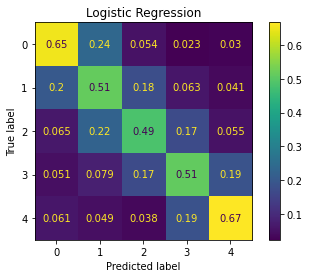

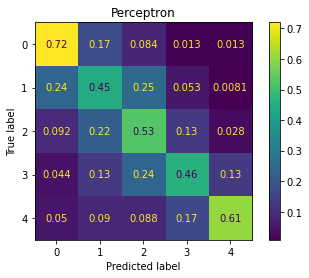

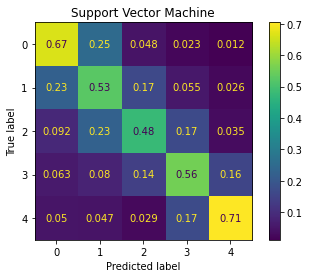

In [221]:
log_reg_y_pred = log_reg_multi_optimal.predict(train_val_overall[1])
log_reg_cm = metrics.confusion_matrix(train_val_overall[3], log_reg_y_pred, normalize = 'true')

print("Logistic Regression F1 Macro Score:" + str(metrics.f1_score(train_val_overall[3], log_reg_y_pred, average = 'macro')))
print("Logistic Regression Accuracy:" + str(metrics.accuracy_score(train_val_overall[3], log_reg_y_pred)))


perceptron_y_pred = perceptron_multi_optimal.predict(train_val_overall[1])
perceptron_cm = metrics.confusion_matrix(train_val_overall[3], perceptron_y_pred, normalize = 'true')

print("Perceptron F1 Macro Score:" + str(metrics.f1_score(train_val_overall[3], perceptron_y_pred, average = 'macro')))
print("Perceptron Accuracy:" + str(metrics.accuracy_score(train_val_overall[3], perceptron_y_pred)))


svm_y_pred = svm_multi_optimal.predict(train_val_overall[1])
svm_cm = metrics.confusion_matrix(train_val_overall[3], svm_y_pred, normalize = 'true')

print("Support Vector Machine F1 Macro Score:" + str(metrics.f1_score(train_val_overall[3], svm_y_pred, average = 'macro')))
print("Support Vector Machine Accuracy:" + str(metrics.accuracy_score(train_val_overall[3], svm_y_pred)))


log_reg_cm_plot = metrics.ConfusionMatrixDisplay(log_reg_cm).plot()
plt.title('Logistic Regression')
perceptron_cm_plot = metrics.ConfusionMatrixDisplay(perceptron_cm).plot()
plt.title('Perceptron')
svm_cm_plot = metrics.ConfusionMatrixDisplay(svm_cm).plot()
plt.title('Support Vector Machine')

plt.show()

Logistic Regression AUC:{0: 0.8919811994810332, 1: 0.8119626371239275, 2: 0.8232691740132838, 3: 0.8442968277165168, 4: 0.9118694902512855, 'macro': 0.8568719918742487}


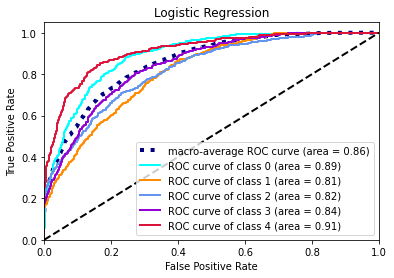

Perceptron AUC:{0: 0.7939929738578274, 1: 0.7722334455667789, 2: 0.7205979469407195, 3: 0.7980905776242564, 4: 0.8843653186257483, 'macro': 0.7940820018668568}


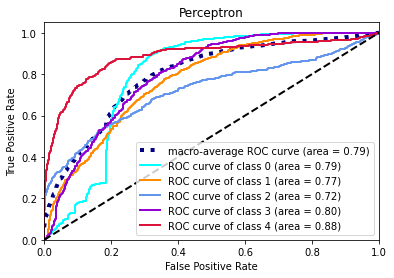

Support Vector Machine AUC:{0: 0.886911794043201, 1: 0.7711777270917056, 2: 0.7937166334035608, 3: 0.8446422508598675, 4: 0.915925344496773, 'macro': 0.8426887246551591}


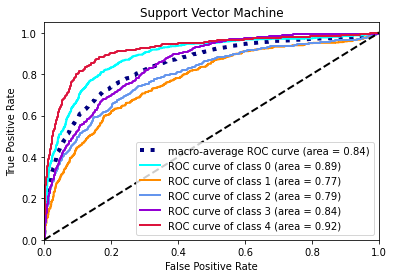

In [224]:
log_reg_y_scores = log_reg_multi_optimal_ovr.decision_function(train_val_overall_ovr[1])
perceptron_y_scores = perceptron_multi_optimal_ovr.decision_function(train_val_overall_ovr[1])
svm_y_scores = svm_multi_optimal_ovr.decision_function(train_val_overall_ovr[1])

log_reg_roc = roc_multiclass("Logistic Regression", 5, train_val_overall_ovr[3], log_reg_y_scores)
perceptron_roc = roc_multiclass("Perceptron", 5, train_val_overall_ovr[3], perceptron_y_scores)
svm_roc = roc_multiclass("Support Vector Machine", 5, train_val_overall_ovr[3], svm_y_scores)   

## Problem 3: Clustering

Clustering is relatively straightforward. Since clustering is an unsupervized learning technique, we cannot perform any hyperparameter testing or cross validation. <br>
We use the k-means algorithm to find 6 unique clusters corresponding to the 6 different product categories in the dataset.

In [93]:
k_means = KMeans(n_clusters = test['category'].nunique(),
                 init = 'k-means++',
                 n_init = 100,
                 max_iter = 100000,
                 algorithm = 'elkan')

k_means.fit(clustering_data_processed)

KMeans(algorithm='elkan', max_iter=100000, n_clusters=6, n_init=100)

Our clusters have a pretty low silhouette score. This means that our 6 clusters are not very well defined. The space between clusters is not very large and the clusters themselves are not very dense.

In [94]:
predicted_category = k_means.labels_
metrics.silhouette_score(clustering_data_processed, predicted_category, metric = 'euclidean')

0.15589616751410287

However, we do obtain a relatively good RAND index when we compare our clusters to the product categories meaning that the clusters generated by our k-means algorithm is somewhat similar to the product category clusters.

In [95]:
metrics.rand_score(predicted_category, category)

0.6553781334123633